# Prediction of PUBG Winning Placement

- **Contribution:** 
    - Anna: Data Preprocessing, random forest
    - Massa: Data Preprocessing, linear regression, Ridge regression, PCA
    - Chang: Lasso regression, Decision Trees, Result, Conclusion


- **Aim**: To predict players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place). As our target is a quantitative value, we will choose use models that can fit to quantitative value only.

- **Method used**: 
    - Regression models: linear regression, ridge regression, lasso regression, and PCA
    - Tree models: Decision Tree, and Random Forest

- **PUBG Introduction**: PUBG stands for Player Unknown's BattleGrounds, which is a popular online game. In a PUBG, players are dropped onto an island empty-handed from a plane. Players have to explore, scavenge, and eliminate other players until only one is left, while facing a slowly shrinking play zone.

- **Data used**: Kaggle collected data through the PUBG Developer API. In each game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences, such as falling too far or running themselves over and eliminating themselves.

# 1. Data Preprocessing

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns #Visulization
pd.set_option('display.max_columns', None)

## A. Data Cleaning

**1.1 Reduce Memory Method**

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
df_train = pd.read_csv('train_V2.csv')
df_train = reduce_mem_usage(df_train)

**1.2 Check null and drop null value**

In [197]:
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [4]:
df_train[df_train['winPlacePerc'].isnull()]
df_train.loc[df_train.matchId == '224a123c53e008']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [5]:
df_train.drop(2744604, inplace=True)

In [200]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory usage: 322.3+ MB


**1.3 Drop rankPoints**

According to data description, this variable is inconsistent and is being deprecated in the API’s next version, so drop it.

In [6]:
print ("Before drop :" ,df_train.shape)
df_train.drop(['rankPoints'], axis=1,inplace=True)
df_train.head()
print ("After drop :", df_train.shape)

Before drop : (4446965, 29)
After drop : (4446965, 28)


Countplot and distplot function

In [7]:
def show_countplot(column):
    plt.figure(figsize=(12,4))
    sns.countplot(data=df_train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(12, 4))
    sns.distplot(df_train[column], bins=50)
    plt.show()

### 1. 4 potential cheaters/just anomalies 

#### 1.4.1 Kill without moving 

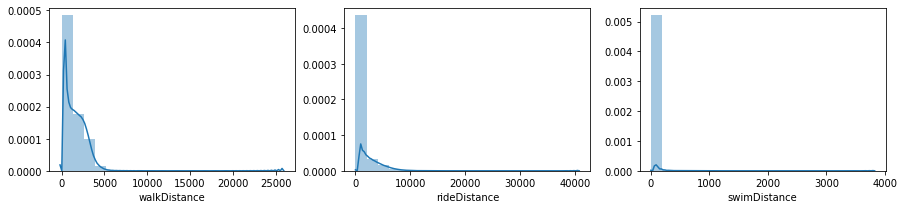

In [147]:
fig, ax = plt.subplots(1,3, figsize=(15, 3))
sns.distplot(df_train.walkDistance, bins = 20, ax=ax[0])  
sns.distplot(df_train.rideDistance, bins = 20, ax=ax[1]) 
sns.distplot(df_train.swimDistance, bins = 20, ax=ax[2]) 
plt.show()

In [8]:
df_train.loc[(df_train['kills'] > 0) & (df_train['walkDistance'] + df_train['rideDistance'] + df_train['swimDistance'] == 0)].head()
df_train.loc[(df_train['kills'] > 0) & (df_train['walkDistance'] + df_train['rideDistance'] + df_train['swimDistance'] == 0)].shape 

(1535, 28)

In [9]:
print("Before drop: ",df_train.shape)
# (4446965, 28)
df_train.drop(df_train.loc[(df_train['kills'] > 0) & (df_train['walkDistance'] + df_train['rideDistance'] + df_train['swimDistance'] == 0)].index, inplace = True)
print("After drop: ",df_train.shape)
# (4445430, 28)

Before drop:  (4446965, 28)
After drop:  (4445430, 28)


We find that there are total 1535 players who have kills without moving any distance, which is impossible in the game. These players are considered as cheaters in the game and we move these cheaters. After removing these outliers, we have total 4445430 obervations now.

#### 1.4.2 Weapons acquired without walking 

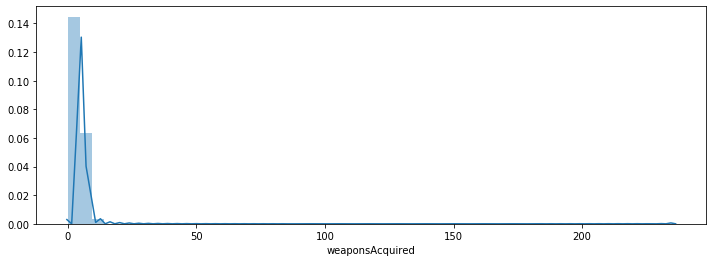

In [153]:
show_distplot('weaponsAcquired')

In [206]:
df_train.loc[(df_train['weaponsAcquired'] > 4) & (df_train['walkDistance'] + df_train['rideDistance'] + df_train['swimDistance'] == 0)].head()
df_train.loc[(df_train['weaponsAcquired'] > 4) & (df_train['walkDistance'] + df_train['rideDistance'] + df_train['swimDistance'] == 0)].shape 


(2574, 28)

In [10]:
print("Before drop: ",df_train.shape)
# (4445430, 28)
df_train.drop(df_train.loc[(df_train['weaponsAcquired'] > 4) & (df_train['walkDistance'] + df_train['rideDistance'] + df_train['swimDistance'] == 0)].index, inplace = True)
print("After drop: ",df_train.shape)
# (4442856, 28)

Before drop:  (4445430, 28)
After drop:  (4442856, 28)


It is also impossible to have weapons without walking, we also consider there players are cheaters and remove from our dataset.

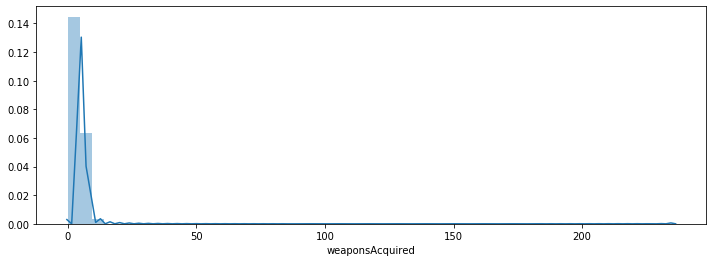

In [208]:
show_distplot('weaponsAcquired')

#### 1.4.3 weapons acquired too much (>80)

In [11]:
print ("Before drop :" ,df_train.shape)
df_train.drop(df_train.loc[(df_train['weaponsAcquired'] > 80)].index, inplace = True)
print ("After drop :" ,df_train.shape)

Before drop : (4442856, 28)
After drop : (4442837, 28)


In [ ]:
We also drop users who acquired weapons more than 80.

#### 1.4.4 heals too many (>40)

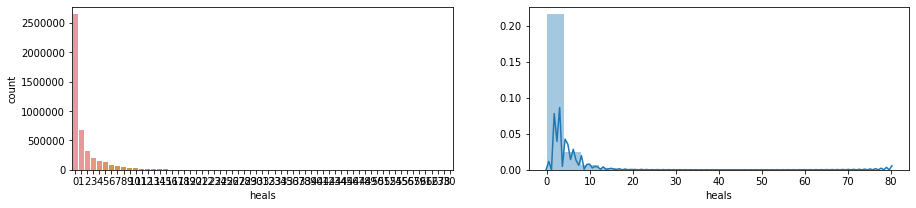

In [210]:
# show_countplot('heals')
# show_distplot('weaponsAcquired')
fig, ax = plt.subplots(1,2, figsize=(15, 3))
sns.countplot(df_train.heals, ax=ax[0])  
sns.distplot(df_train.heals, bins = 20, ax=ax[1]) 
plt.show()


In [12]:
print ("Before drop :" ,df_train.shape)
df_train.drop(df_train.loc[(df_train['heals'] > 40)].index, inplace = True)
print ("After drop :" ,df_train.shape)

Before drop : (4442837, 28)
After drop : (4442722, 28)


Remove heals more than 40.

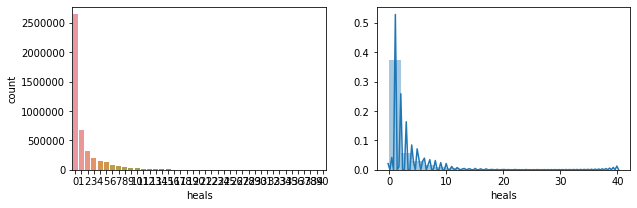

In [212]:
fig, ax = plt.subplots(1,2, figsize=(10, 3))
sns.countplot(df_train.heals, ax=ax[0])  
sns.distplot(df_train.heals, bins = 20, ax=ax[1]) 
plt.show()

#### 1.4.5 revive too many (>20)

In [213]:
import seaborn as sns 
def show_countplot(column):
    plt.figure(figsize=(12,4))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()

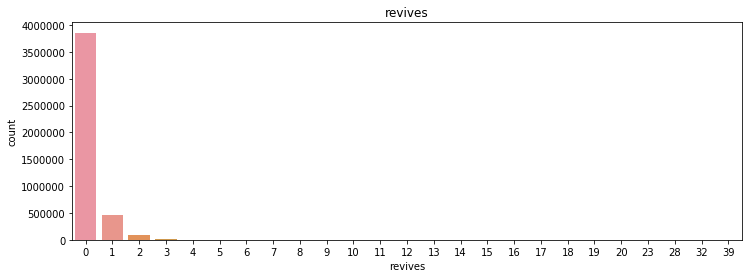

In [160]:
show_countplot('revives')

In [13]:
df_train.loc[(df_train['revives'] > 20)].shape
print ("Before drop :" ,df_train.shape)
df_train.drop(df_train.loc[(df_train['revives'] > 20)].index, inplace = True)
print ("After drop :" ,df_train.shape)

Before drop : (4442722, 28)
After drop : (4442716, 28)


Remove heals more than 20.

#### 1.4.6 Too much roadkills(>10)

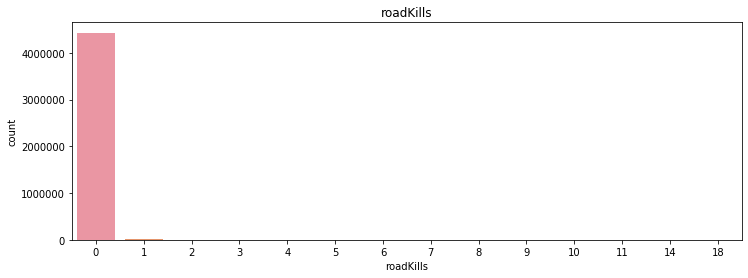

In [162]:
show_countplot('roadKills')

In [14]:
print ("Before drop :" ,df_train.shape)
df_train.drop(df_train.loc[(df_train['roadKills'] > 10)].index, inplace = True)
print ("After drop :" ,df_train.shape)

Before drop : (4442716, 28)
After drop : (4442712, 28)


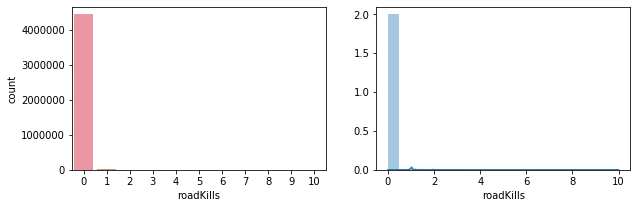

In [164]:
fig, ax = plt.subplots(1,2, figsize=(10, 3))
sns.countplot(df_train.roadKills, ax=ax[0])  
sns.distplot(df_train.roadKills, bins = 20, ax=ax[1]) 
plt.show()

In [216]:
df_train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00,4442712.00
mean,0.23,1.11,nan,0.66,0.23,1.37,47.63,505.32,0.92,0.54,nan,1579.62,44.53,43.04,0.16,nan,0.00,nan,0.02,0.01,nan,3.65,606.80,nan
std,0.59,1.72,nan,1.14,0.60,2.67,27.45,627.60,1.55,0.71,nan,258.45,23.82,23.27,0.47,nan,0.07,nan,0.17,0.09,nan,2.42,739.77,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,133.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,24.00,0.00,0.00,0.00,0.00,1367.00,28.00,27.00,0.00,0.00,0.00,0.00,0.00,0.00,155.75,2.00,0.00,0.20
50%,0.00,0.00,84.19,0.00,0.00,0.00,47.00,0.00,0.00,0.00,0.00,1438.00,30.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,687.50,3.00,0.00,0.46
75%,0.00,2.00,186.00,1.00,0.00,2.00,71.00,1172.00,1.00,1.00,21.31,1851.00,49.00,47.00,0.00,0.42,0.00,0.00,0.00,0.00,1977.00,5.00,1495.00,0.74
max,21.00,33.00,6616.00,53.00,64.00,40.00,101.00,2170.00,72.00,20.00,1094.00,2237.00,100.00,100.00,20.00,40704.00,10.00,3824.00,12.00,5.00,25776.00,80.00,2013.00,1.00


**1.5 Drop Id, groupId,matchId column**

In [15]:
print ("Before drop :" ,df_train.shape)
df_train.drop(['Id'], axis=1,inplace=True)
df_train.head()
print ("After drop :", df_train.shape)

Before drop : (4442712, 28)
After drop : (4442712, 27)


**1.6 Check VIF inflation factor and multicorrelation**

In [218]:
# Remove predict column winPlacePerc
df_vif = df_train
df_vif = reduce_mem_usage(df_vif)
cols = [col for col in df_vif.columns if col not in ['winPlacePerc']]
df_vif = df_vif[cols]
# Remove Category matchType column
cols = [col for col in df_vif.columns if col not in ['matchType']]
df_vif = df_vif[cols]
cols = [col for col in df_vif.columns if col not in ['Id','groupId','matchId']]
df_vif = df_vif[cols]
df_vif.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,28,26,0,0.00,0,0.00,0,0,244.75,1,1466
1,0,0,91.50,0,0,0,57,0,0,0,0.00,1777,26,25,0,0.00,0,11.04,0,0,1434.00,5,0
2,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,50,47,0,0.00,0,0.00,0,0,161.75,2,0
3,0,0,32.91,0,0,0,75,0,0,0,0.00,1436,31,30,0,0.00,0,0.00,0,0,202.75,3,0
4,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,97,95,0,0.00,0,0.00,0,0,49.75,2,0


In [219]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
exogs = df_vif.columns
df_vif_cor = get_vif(exogs=exogs, data=df_vif)

In [220]:
df_vif_cor

,VIF,Tolerance
DBNOs,2.84,0.35
assists,1.29,0.78
boosts,2.33,0.43
damageDealt,6.09,0.16
headshotKills,1.86,0.54
heals,1.50,0.67
killPlace,5.14,0.19
killPoints,32.13,0.03
killStreaks,4.91,0.20
kills,8.09,0.12


The presence of multicolinearity will pose difficulties in regression context because it is difficult in separating out individual effect of collinear variables on the response. 

Here, we use VIF to check multicolinearity. From VIF result, we can see that maxPlace and numGroups have a high variance inflation factor whichh is 258 and 257. 

Refer to the definition of there two variables, maxPlace means the worst placement we have data for in the match and numGroups means total groups' amount we have data for in the match. These two variables actually imply the same information in the data. So we choose to drop maxPlace column to avoid multicolinearity.

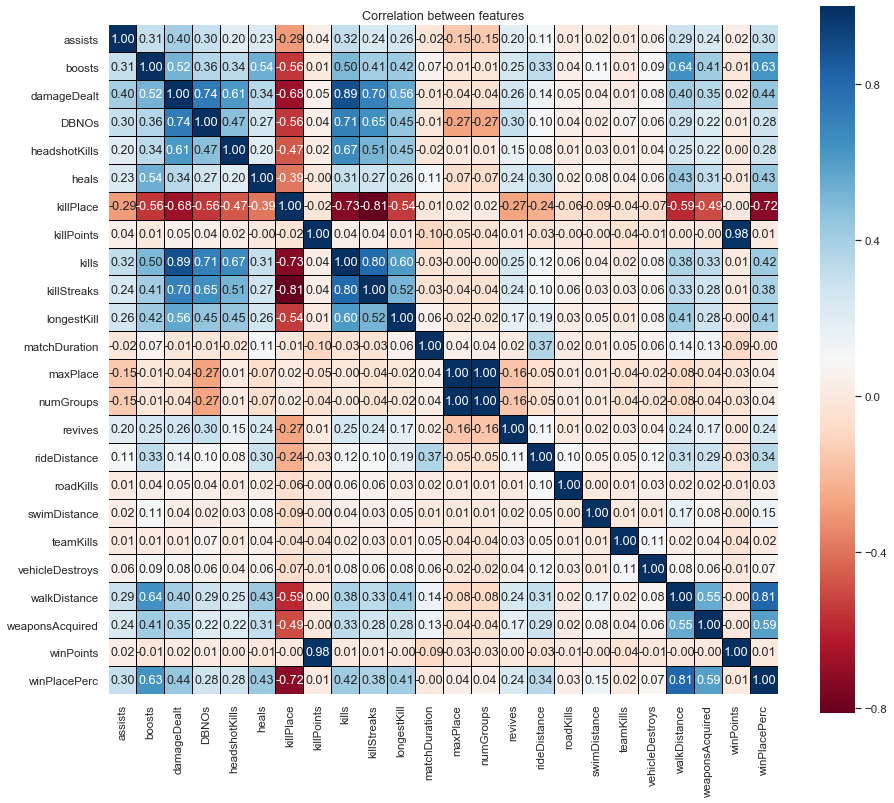

In [221]:
# Remove predict column winPlacePerc
df_cor= df_train
df_cor = reduce_mem_usage(df_cor)
# Remove Category matchType column
cols = [col for col in df_cor.columns if col not in ['matchType']]
df_cor = df_cor[cols]
cols = [col for col in df_cor.columns if col not in ['Id','groupId','matchId']]
df_cor = df_cor[cols]
df_cor.head()

sns.set(font_scale=1.05)
plt.figure(figsize=(15, 13))
#cmap='YlGnBu'
sns.heatmap(df_cor.corr(),linewidths=0.01,
            square=True,annot=True,cmap='RdBu',linecolor="black",fmt='.2f')
plt.title('Correlation between features');

In [16]:
print ("Before drop :" ,df_train.shape)
df_train.drop(['maxPlace'], axis=1,inplace=True)
df_train.head()
print ("After drop :", df_train.shape)

Before drop : (4442712, 27)
After drop : (4442712, 26)


In [17]:
df_train_linear = df_train

In [18]:
print ("Before drop :" ,df_train_linear.shape)
df_train_linear.drop(['winPoints'], axis=1,inplace=True)
df_train_linear.head()
print ("After drop :", df_train_linear.shape)

Before drop : (4442712, 26)
After drop : (4442712, 25)


## 1.7 New Features 
#### 1.7.1 'playersJoined' 
Although each match is allowed up to 100 players, most of matches have less than 100 players. There's no such variable describing players number in each match, so we add one new feature "playersJoined" to the dataset.

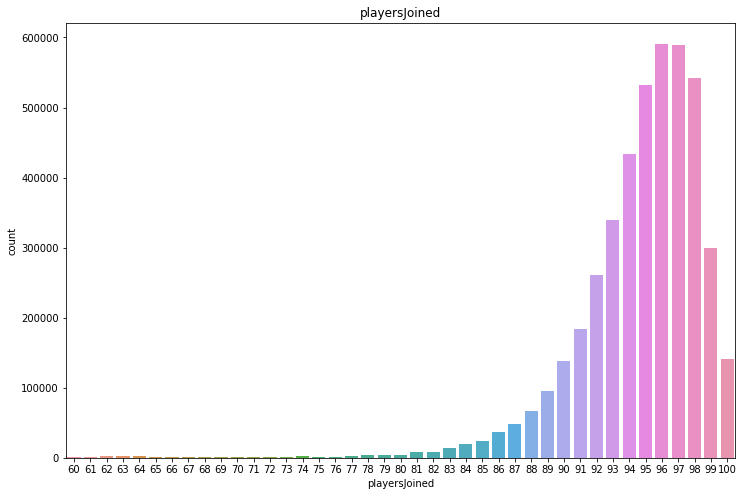

In [166]:
df_train['playersJoined'] = df_train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(12,8))
sns.countplot(df_train[df_train['playersJoined']>=60]['playersJoined'])
plt.title('playersJoined')
plt.show()

In [167]:
print ("Before add :" ,df_train.shape)
df_train['playersJoined'] = df_train.groupby('matchId')['matchId'].transform('count')
print ("After add :" ,df_train.shape)

Before add : (4442712, 28)
After add : (4442712, 28)


In [68]:
df_train.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,...,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336,96
1,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,...,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137,91
2,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,...,0.000000,0,0.000000,0,0,161.75,2,0,0.775391,98
3,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,...,0.000000,0,0.000000,0,0,202.75,3,0,0.166748,91
4,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,...,0.000000,0,0.000000,0,0,49.75,2,0,0.187500,97


### 1.8 Combined features
#### 1.8.1 "Total Distance" = rideDistance + walkDistance + swimDistance

In [168]:
df_train['TotalDistance'] = (df_train['walkDistance'] + df_train['rideDistance'] + df_train['swimDistance'])
df_train.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,TotalDistance
0,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336,96,244.75
1,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137,91,1445.00
2,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391,98,161.75
3,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748,91,202.75
4,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500,97,49.75


#### 1.8.2 "healsandboosts"

In [169]:
df_train['healsandboosts'] = (df_train['heals'] + df_train['boosts'])
df_train.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,TotalDistance,healsandboosts
0,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336,96,244.75,0
1,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137,91,1445.00,0
2,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391,98,161.75,0
3,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748,91,202.75,0
4,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500,97,49.75,0


### 1.9. Categorial Variables 
**1.9.1 Matchtype**

matchType here is category variable, so we will change it to dummy variable. 

There are total 16 matchType, so we will change to 15 dummy variables.

In [239]:
df_train['matchType'].value_counts()
# df_train['matchType'].nunique()

squad-fpp           1756116
duo-fpp              996658
squad                626511
solo-fpp             536573
duo                  313573
solo                 179521
normal-squad-fpp      16074
crashfpp               6287
normal-duo-fpp         5407
flaretpp               2505
normal-solo-fpp        1487
flarefpp                718
normal-squad            442
crashtpp                371
normal-solo             278
normal-duo              191
Name: matchType, dtype: int64

In [19]:
# dummies = pd.get_dummies(df_train_linear[['matchType']],drop_first = True)
# dummies.info()
df_train_linear = pd.get_dummies(df_train_linear, columns=['matchType'],drop_first = True)
df_train_linear.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,26,0,0.000000,0,0.000000,0,0,244.75,1,0.444336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,25,0,0.004501,0,11.039062,0,0,1434.00,5,0.640137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,47,0,0.000000,0,0.000000,0,0,161.75,2,0.775391,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,30,0,0.000000,0,0.000000,0,0,202.75,3,0.166748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,95,0,0.000000,0,0.000000,0,0,49.75,2,0.187500,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [230]:
df_train_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4442712 entries, 0 to 4446965
Data columns (total 39 columns):
groupId                       object
matchId                       object
assists                       int8
boosts                        int8
damageDealt                   float16
DBNOs                         int8
headshotKills                 int8
heals                         int8
killPlace                     int8
killPoints                    int16
kills                         int8
killStreaks                   int8
longestKill                   float16
matchDuration                 int16
numGroups                     int8
revives                       int8
rideDistance                  float16
roadKills                     int8
swimDistance                  float16
teamKills                     int8
vehicleDestroys               int8
walkDistance                  float16
weaponsAcquired               int8
winPlacePerc                  float16
matchType_crashtpp     

#### Rename dummy variables 

In [20]:
df_train_linear.rename(columns={'matchType_duo-fpp':'matchType_duo_fpp','matchType_normal-duo': 'matchType_normal_duo', 'matchType_normal-duo-fpp': 'matchType_normal_duo_fpp','matchType_normal-solo': 'matchType_normal_solo','matchType_normal-solo-fpp': 'matchType_normal_solo_fpp','matchType_normal-squad': 'matchType_normal_squad','matchType_normal-squad-fpp': 'matchType_normal_squad_fpp','matchType_solo-fpp':'matchType_solo_fpp','matchType_squad-fpp':'matchType_squad_fpp'}, inplace=True)
df_train_linear.head()


,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,matchType_crashtpp,matchType_duo,matchType_duo_fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal_duo,matchType_normal_duo_fpp,matchType_normal_solo,matchType_normal_solo_fpp,matchType_normal_squad,matchType_normal_squad_fpp,matchType_solo,matchType_solo_fpp,matchType_squad,matchType_squad_fpp
0,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,26,0,0.000000,0,0.000000,0,0,244.75,1,0.444336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,25,0,0.004501,0,11.039062,0,0,1434.00,5,0.640137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,47,0,0.000000,0,0.000000,0,0,161.75,2,0.775391,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,30,0,0.000000,0,0.000000,0,0,202.75,3,0.166748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,95,0,0.000000,0,0.000000,0,0,49.75,2,0.187500,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 1.10 Drop Group ID & Match ID

In [21]:
print ("Before drop :" ,df_train_linear.shape)
df_train_linear.drop(['groupId','matchId'],axis=1,inplace = True)
pd.set_option('display.max_columns', None)
df_train_linear.head()
print ("After drop :", df_train_linear.shape)

Before drop : (4442712, 39)
After drop : (4442712, 37)


In [233]:
df_train_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4442712 entries, 0 to 4446965
Data columns (total 37 columns):
assists                       int8
boosts                        int8
damageDealt                   float16
DBNOs                         int8
headshotKills                 int8
heals                         int8
killPlace                     int8
killPoints                    int16
kills                         int8
killStreaks                   int8
longestKill                   float16
matchDuration                 int16
numGroups                     int8
revives                       int8
rideDistance                  float16
roadKills                     int8
swimDistance                  float16
teamKills                     int8
vehicleDestroys               int8
walkDistance                  float16
weaponsAcquired               int8
winPlacePerc                  float16
matchType_crashtpp            uint8
matchType_duo                 uint8
matchType_duo_fpp        

## B. Normalize Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

#import cleaned data 
df_train = pd.read_csv('cleaned_train.csv')

In [2]:
pd.set_option('display.max_columns', None)
df_train.drop(df_train.columns[0], axis=1)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,TotalDistance,healsandboosts,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0.000,0,0,0,60,1241,0,0,0.000,1306,26,-1,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444,96,244.8000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,91.470,0,0,0,57,0,0,0,0.000,1777,25,1484,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400,91,1445.0445,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,68.000,0,0,0,47,0,0,0,0.000,1318,47,1491,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755,98,161.8000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,32.900,0,0,0,75,0,0,0,0.000,1436,30,1408,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667,91,202.7000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,100.000,0,0,0,45,0,1,1,58.530,1424,95,1560,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875,97,49.7500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,100.000,1,1,0,44,0,1,1,18.440,1395,28,1418,0,0.0000,0,0.000,0,0,34.70,1,0,0.0370,95,34.7000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0.000,0,0,0,96,1262,0,0,0.000,1316,28,-1,0,0.0000,0,0.000,0,0,13.50,1,1497,0.0000,97,13.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,8.538,0,0,0,48,1000,0,0,0.000,1967,92,-1,0,2004.0000,0,0.000,0,0,1089.00,6,1500,0.7368,96,3093.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,0,0,51.600,0,0,0,64,0,0,0,0.000,1375,27,1493,0,0.0000,0,0.000,0,0,799.90,4,0,0.3704,97,799.9000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,0,0,37.270,0,0,0,74,0,0,0,0.000,1930,27,1349,0,0.0000,0,0.000,0,0,65.67,1,0,0.2143,97,65.6700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**Check the range for each column:**

In [9]:
#normalize numeric variables, leave categorial var behind
train_numeric = pd.DataFrame(df_train.iloc[:,:28])
train_numeric = train_numeric.drop(train_numeric.columns[0], axis=1)
train_numeric = train_numeric.drop(train_numeric.columns[13], axis=1)
train_numeric = train_numeric.drop(train_numeric.columns[22], axis=1)

train_numeric.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,playersJoined,TotalDistance,healsandboosts
0,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,26,0,0.0000,0,0.00,0,0,244.80,1,1466,96,244.8000,0
1,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,25,0,0.0045,0,11.04,0,0,1434.00,5,0,91,1445.0445,0
2,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,47,0,0.0000,0,0.00,0,0,161.80,2,0,98,161.8000,0
3,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,30,0,0.0000,0,0.00,0,0,202.70,3,0,91,202.7000,0
4,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,95,0,0.0000,0,0.00,0,0,49.75,2,0,97,49.7500,0


Extracted from : http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

In [10]:
#Z score normalization : use mean & std 
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler().fit_transform(train_numeric.values)
print(std_scaler)

scaled_features_df = pd.DataFrame(std_scaler, index=train_numeric.index, columns=train_numeric.columns)
scaled_features_df.head()

[[-0.39774999 -0.64548209 -0.76684943 ...  0.27143887 -0.69689156
  -0.63969956]
 [-0.39774999 -0.64548209 -0.22964045 ... -0.49481473 -0.14717729
  -0.63969956]
 [ 1.30634345 -0.64548209 -0.36748122 ...  0.57794031 -0.73490572
  -0.63969956]
 ...
 [-0.39774999 -0.64548209 -0.41998639 ...  0.57794031 -0.44678404
  -0.63969956]
 [-0.39774999  1.68546283  0.29265095 ... -0.03506257  0.44957882
   0.90973847]
 [-0.39774999  0.51999037  0.80713119 ...  0.57794031  0.38774857
   0.13501945]]


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,playersJoined,TotalDistance,healsandboosts
0,-0.397750,-0.645482,-0.766849,-0.575097,-0.377065,-0.512913,0.450598,1.172219,-0.594873,-0.765382,-0.451281,-1.058702,-0.732214,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.769278,-1.094687,1.161446,0.271439,-0.696892,-0.6397
1,-0.397750,-0.645482,-0.229640,-0.575097,-0.377065,-0.512913,0.341328,-0.805159,-0.594873,-0.765382,-0.451281,0.763725,-0.775188,-0.349681,-0.404726,-0.048276,0.213880,-0.142621,-0.085535,0.235526,0.555471,-0.820254,-0.494815,-0.147177,-0.6397
2,1.306343,-0.645482,-0.367481,-0.575097,-0.377065,-0.512913,-0.022905,-0.805159,-0.594873,-0.765382,-0.451281,-1.012271,0.170229,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.839409,-0.682147,-0.820254,0.577940,-0.734906,-0.6397
3,-0.397750,-0.645482,-0.573626,-0.575097,-0.377065,-0.512913,0.996948,-0.805159,-0.594873,-0.765382,-0.451281,-0.555697,-0.560320,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.804850,-0.269608,-0.820254,-0.494815,-0.716173,-0.6397
4,-0.397750,-0.645482,-0.179543,-0.575097,-0.377065,-0.512913,-0.095752,-0.805159,0.049129,0.641826,0.697320,-0.602128,2.232956,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.934084,-0.682147,-0.820254,0.424690,-0.786225,-0.6397


In [11]:
discrete_df = pd.DataFrame(df_train.iloc[:,28:])
discrete_df.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [13]:
y_df = pd.DataFrame(df_train.iloc[:,24])

In [14]:
normalized_df = pd.concat([scaled_features_df, discrete_df, y_df], axis =1)

In [17]:
normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442712 entries, 0 to 4442711
Data columns (total 42 columns):
assists                       float64
boosts                        float64
damageDealt                   float64
DBNOs                         float64
headshotKills                 float64
heals                         float64
killPlace                     float64
killPoints                    float64
kills                         float64
killStreaks                   float64
longestKill                   float64
matchDuration                 float64
numGroups                     float64
revives                       float64
rideDistance                  float64
roadKills                     float64
swimDistance                  float64
teamKills                     float64
vehicleDestroys               float64
walkDistance                  float64
weaponsAcquired               float64
winPoints                     float64
playersJoined                 float64
TotalDistance

In [44]:
normalized_df.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,TotalDistance,healsandboosts,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,-0.397750,-0.645482,-0.766849,-0.575097,-0.377065,-0.512913,0.450598,1.172219,-0.594873,-0.765382,-0.451281,-1.058702,-0.732214,-1.211694,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.769278,-1.094687,1.161446,-0.092974,0.271439,-0.696892,-0.6397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-0.397750,-0.645482,-0.229640,-0.575097,-0.377065,-0.512913,0.341328,-0.805159,-0.594873,-0.765382,-0.451281,0.763725,-0.775188,0.804021,-0.349681,-0.404726,-0.048276,0.213880,-0.142621,-0.085535,0.235526,0.555471,-0.820254,0.543611,-0.494815,-0.147177,-0.6397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1.306343,-0.645482,-0.367481,-0.575097,-0.377065,-0.512913,-0.022905,-0.805159,-0.594873,-0.765382,-0.451281,-1.012271,0.170229,0.813523,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.839409,-0.682147,-0.820254,0.984600,0.577940,-0.734906,-0.6397,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.397750,-0.645482,-0.573626,-0.575097,-0.377065,-0.512913,0.996948,-0.805159,-0.594873,-0.765382,-0.451281,-0.555697,-0.560320,0.700860,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.804850,-0.269608,-0.820254,-0.996757,-0.494815,-0.716173,-0.6397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.397750,-0.645482,-0.179543,-0.575097,-0.377065,-0.512913,-0.095752,-0.805159,0.049129,0.641826,0.697320,-0.602128,2.232956,0.907182,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.934084,-0.682147,-0.820254,-0.929063,0.424690,-0.786225,-0.6397,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
normalized_df.to_csv("normalized.csv", mode='w')

In [46]:
result = pd.read_csv('normalized_train.csv')
result.head(3)

,Unnamed: 0,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,TotalDistance,healsandboosts,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,-0.397750,-0.645482,-0.766849,-0.575097,-0.377065,-0.512913,0.450598,1.172219,-0.594873,-0.765382,-0.451281,-1.058702,-0.732214,-1.211694,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.769278,-1.094687,1.161446,-0.092974,0.271439,-0.696892,-0.6397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,-0.397750,-0.645482,-0.229640,-0.575097,-0.377065,-0.512913,0.341328,-0.805159,-0.594873,-0.765382,-0.451281,0.763725,-0.775188,0.804021,-0.349681,-0.404726,-0.048276,0.213880,-0.142621,-0.085535,0.235526,0.555471,-0.820254,0.543611,-0.494815,-0.147177,-0.6397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,1.306343,-0.645482,-0.367481,-0.575097,-0.377065,-0.512913,-0.022905,-0.805159,-0.594873,-0.765382,-0.451281,-1.012271,0.170229,0.813523,-0.349681,-0.404729,-0.048276,-0.147902,-0.142621,-0.085535,-0.839409,-0.682147,-0.820254,0.984600,0.577940,-0.734906,-0.6397,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442712 entries, 0 to 4442711
Data columns (total 44 columns):
Unnamed: 0                    int64
assists                       float64
boosts                        float64
damageDealt                   float64
DBNOs                         float64
headshotKills                 float64
heals                         float64
killPlace                     float64
killPoints                    float64
kills                         float64
killStreaks                   float64
longestKill                   float64
matchDuration                 float64
numGroups                     float64
rankPoints                    float64
revives                       float64
rideDistance                  float64
roadKills                     float64
swimDistance                  float64
teamKills                     float64
vehicleDestroys               float64
walkDistance                  float64
weaponsAcquired               float64
winPoints      

# 2. Apply Machine Learning 

**2.1. Linear Regression:**

In [259]:
df_train_linear.shape

(4442712, 37)

In [22]:
X = df_train_linear.drop(columns = ['winPlacePerc']) #all columns except target
y = df_train_linear['winPlacePerc'] # Only target variable

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [24]:
import statsmodels.formula.api as smf #statsmodels is a Python module for statistics
import statsmodels.api as sm

exog = sm.add_constant(X_train)
model = sm.OLS(y_train, exog).fit()
print(model.summary())

/Users/apple/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 4.531e+05
Date:                Fri, 20 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:59:32   Log-Likelihood:             2.1043e+06
No. Observations:             3109898   AIC:                        -4.208e+06
Df Residuals:                 3109861   BIC:                        -4.208e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
exog = sm.add_constant(X_test)
y_predictions = model.predict(exog)
MSE = mean_squared_error(y_test,y_predictions)
MAE = mean_absolute_error(y_test,y_predictions)
print('Parameters: ')
print(model.params)
print('R2: ', model.rsquared)
print('TEST MSE:',MSE)
print('MAE:',MAE)


/Users/apple/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Parameters: 
const                         0.596298
assists                       0.015482
boosts                        0.013925
damageDealt                   0.000069
DBNOs                        -0.007240
headshotKills                 0.002067
heals                         0.000578
killPlace                    -0.007472
killPoints                   -0.000002
kills                        -0.013400
killStreaks                  -0.149162
longestKill                   0.000006
matchDuration                -0.000159
numGroups                     0.006531
revives                       0.012331
rideDistance                  0.000018
roadKills                     0.019074
swimDistance                  0.000111
teamKills                    -0.014870
vehicleDestroys               0.011425
walkDistance                  0.000110
weaponsAcquired               0.012336
matchType_crashtpp            0.034191
matchType_duo                 0.089069
matchType_duo_fpp             0.091911
matchType_fl

In [249]:
# model values
model_fitted_y = model.fittedvalues
# model residuals
model_residuals = model.resid
# normalized residuals
model_norm_residuals = model.get_influence().resid_studentized_internal

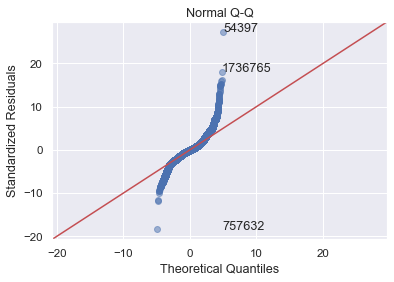

In [250]:
# fig = sm.qqplot(model_residuals)
# plt.show()
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

This qqplot shows if the residuals are normally distributed. A good normal QQ plot has all of the residuals lying on or close to the red line. However, From the above figure, we can see quite a few points are far away from the line, which indicates errors are not normally distributed. 

The middle part of data fall along the line, while the both two sides data are far away from the line. So our data has more extreme points, which means there are many good excellent players as well as poor players.

**2.2 Ridge Regression:**

In [105]:
df_train_linear
X_train, X_test, y_train, y_test

In [28]:
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

In [251]:
10**np.linspace(10,-2,15)*0.5

array([5.00000000e+09, 6.94747747e+08, 9.65348864e+07, 1.34134790e+07,
       1.86379686e+06, 2.58973734e+05, 3.59842837e+04, 5.00000000e+03,
       6.94747747e+02, 9.65348864e+01, 1.34134790e+01, 1.86379686e+00,
       2.58973734e-01, 3.59842837e-02, 5.00000000e-03])

In [29]:
#(np.logspace(10, -2, num=5))
alphas = 10**np.linspace(10,-2,15)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X_train), y_train)
    coefs.append(ridge.coef_)

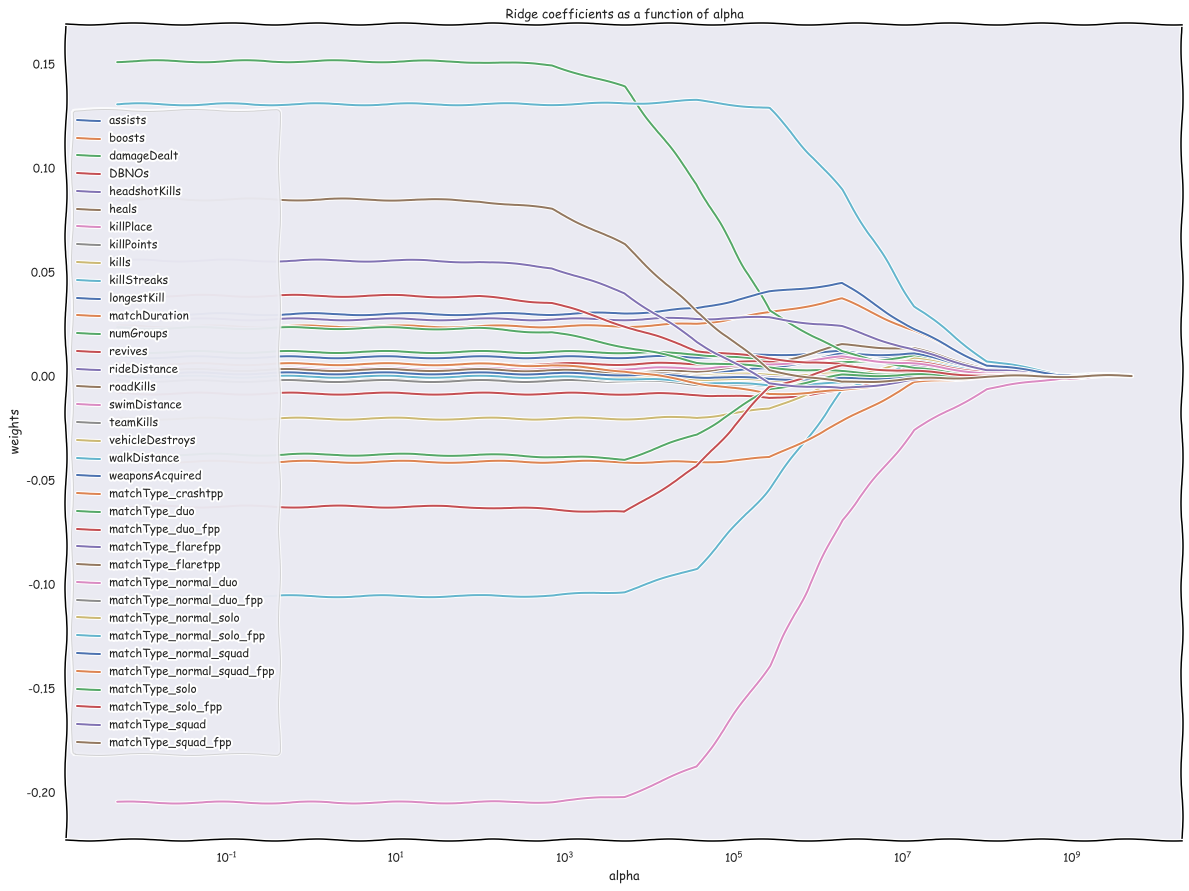

In [292]:
plt.figure(figsize = (20, 15))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of alpha')
plt.legend(X_train)

In [30]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)
ridgecv.alpha_

1.863796860157469

In [31]:
ridge2 = Ridge()
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train) 
print('MSE: ',mean_squared_error(y_test, ridge2.predict(scale(X_test))))#should use test X and test y, not cleaned test X and Y yet
print('MAE: ',mean_absolute_error(y_test, ridge2.predict(scale(X_test))))#should use test X and test y, not cleaned test X and Y yet


MSE:  0.015085865831683459
MAE:  0.08981953544274494


In [295]:
ridgecoefs0 = pd.Series(ridge2.coef_, index = X_test.columns)
ridgeintercept0 = pd.Series(ridge2.intercept_, index = ['Intercept'])
ridgetable0 = pd.DataFrame(pd.concat([ridgeintercept0, ridgecoefs0]))
ridgetable0.columns = ['Coefficients']
ridgetable0

,Coefficients
Intercept,0.47295
assists,0.00903
boosts,0.02384
damageDealt,0.01157
DBNOs,-0.00843
headshotKills,0.00127
heals,0.00155
killPlace,-0.20492
killPoints,-0.00114
kills,-0.02046



#### 2.3. PCA

In [32]:
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold as KF, cross_val_score
from sklearn.decomposition import PCA


In [261]:
np.arange(1, 37)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [33]:
pca_train = PCA()
X_scaled_train = pca_train.fit_transform(scale(X_train))
print(pca_train.components_.shape)

(36, 36)


In [34]:
len(X_scaled_train)

3109898

In [35]:
pca_train = PCA()
X_scaled_train = pca_train.fit_transform(scale(X_train))
n = len(X_scaled_train)

lmtrain = LinearRegression()

kf10train = KF(n_splits=10, shuffle=True, random_state=42)
MSEdftrain= pd.DataFrame()

# calculating MSE with only the intercept through cross-validation
msetrain = -1*cross_val_score(lmtrain, np.ones((n,1)), y_train.ravel(), cv=kf10train, scoring='neg_mean_squared_error').mean()    
MSEdftrain = MSEdftrain.append([msetrain])

# calculating MSE for the 36 components through cross-validation
for i in np.arange(1, 37):
    msetrain = -1*cross_val_score(lmtrain, X_scaled_train[:,:i], y_train.ravel(), cv=kf10train, scoring='neg_mean_squared_error').mean()
    MSEdftrain = MSEdftrain.append([msetrain])
    
MSEdftrain.reset_index(drop=True, inplace=True)
MSEdftrain.columns = ['MSE']
MSEdftrain


,MSE
0,0.094478
1,0.052665
2,0.051086
3,0.040620
4,0.039024
5,0.034537
6,0.032915
7,0.032910
8,0.032807
9,0.032749


In [267]:
# pd.options.display.float_format = '{:.5f}'.format

In [280]:
# MSEdftrain

In [269]:
# plt.xkcd()
# plt.figure(figsize= (25, 10))
# plt.plot(MSEdftrain)
# plt.title('Train MSE vs number of principal components', fontsize = 30)
# plt.xlabel('number of principal components', fontsize = 20)
# plt.ylabel('MSE', fontsize = 20)

Text(0.5, 1.0, 'Train MSE vs number of principal components')

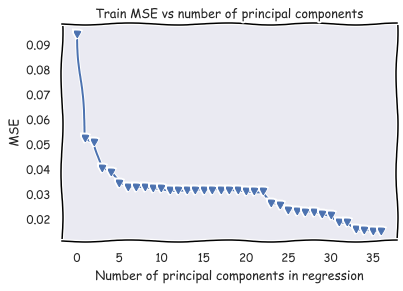

In [265]:
plt.plot(np.array(MSEdftrain), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Train MSE vs number of principal components')


The above plot indicates that the lowest training MSE is reached when doing regression on 36 components, however  when components equal 33, the MSE is roughly same with all components. This suggests that a model uses just 33 predictors might suffice.


In [286]:
exp_var_ratio_scaled

,0
0,17.56000
1,24.08000
2,29.37000
3,33.22000
4,36.67000
5,39.93000
6,42.96000
7,45.97000
8,48.93000
9,51.84000


Text(0, 0.5, 'explained variance ratio')

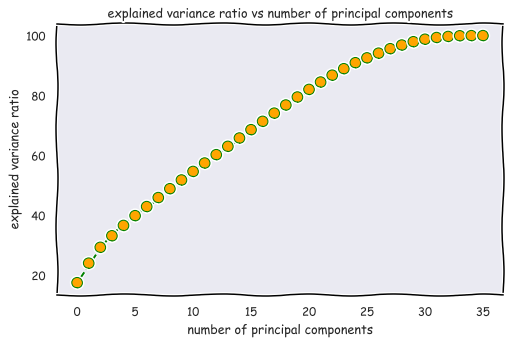

In [276]:

# plotting explained variance ratio
exp_var_ratio_scaled = pd.DataFrame(np.cumsum(np.round(pca_train.explained_variance_ratio_, decimals=4)*100))
plt.xkcd()
plt.figure(figsize= (8, 5))
plt.plot(exp_var_ratio_scaled, color='green', linestyle ='-.', marker='o', markersize=10, markerfacecolor='orange')
plt.title('explained variance ratio vs number of principal components')
plt.xlabel('number of principal components')
plt.ylabel('explained variance ratio')

In [36]:
X_reduced_test = pca_train.transform(scale(X_test))[:,:34]
# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_scaled_train[:,:34], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
MSETest = mean_squared_error(y_test, pred)
MAETest = mean_absolute_error(y_test, pred)
MSETest

0.015822239294206113

In [288]:

# pca_test = PCA(n_components=33)
# X_scaled_test = pca_test.fit_transform(scale(X_test))
# pcrfit33 = LinearRegression().fit(X_scaled_train, y_train)
# pcrpred33 = pcrfit33.predict(X_scaled_test)

# pcrerror33 = mean_squared_error(y_test, pcrpred33)
# pcrerror33

In [37]:
MAETest

0.09200489423152275

**2.4. Lasso:**

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('normalized_train.csv',encoding = 'ascii')

In [4]:
train = train.drop(['Unnamed: 0'], axis=1)
train.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,-0.397750,-0.645482,-0.766849,-0.575097,-0.377065,-0.512913,0.450598,1.172219,-0.594873,-0.765382,...,0,0,0,0,0,0,0,0,0,1
1,-0.397750,-0.645482,-0.229640,-0.575097,-0.377065,-0.512913,0.341328,-0.805159,-0.594873,-0.765382,...,0,0,0,0,0,0,0,0,0,1
2,1.306343,-0.645482,-0.367481,-0.575097,-0.377065,-0.512913,-0.022905,-0.805159,-0.594873,-0.765382,...,0,0,0,0,0,0,0,0,0,0
3,-0.397750,-0.645482,-0.573626,-0.575097,-0.377065,-0.512913,0.996948,-0.805159,-0.594873,-0.765382,...,0,0,0,0,0,0,0,0,0,1
4,-0.397750,-0.645482,-0.179543,-0.575097,-0.377065,-0.512913,-0.095752,-0.805159,0.049129,0.641826,...,0,0,0,0,0,0,0,1,0,0


In [5]:
#Split train set into training data and testing data
X=train.drop(['winPlacePerc'], axis=1)
y=train['winPlacePerc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In linear regression, only the residual sum of squares (RSS) is minimized, wherears in ridge and lasso regression, a penalty is applied on coefficient values to regularize the coefficients with the tuning parameter λ.Shrinking the coefficient estimates can significantly reduce their variance. 

Unlike ridge regression, the lasso uses an L1 penalty, which has the effect of forcing some of the coefficient estimates to be exactly equal to 0 when λ is sufficiently large. By doing variable selection, we eliminate some insignificant variables. Models generated from the lasso are generally easier to interpret than those produced by ridge regression.

Implementing the lasso regression requires us to find the value of the tuning parameter λ first. We choose a grid of λ values and select the λ for which the R-squared value is the largest.R-squared value measures how close the data are to the regression line.

In [29]:
alphas = [1e-4,1e-3,1e-2,0.1,0.5,1.0,5.0,10.0]
initial_score = 0
train_score = []
test_score = []

def train_and_get_score(model):
    model.fit(X_train[:10000], y_train[:10000])
    train_score = model.score(X_train[:10000],y_train[:10000])
    test_score = model.score(X_test[:1000],y_test[:1000])
    return train_score, test_score

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    r_train,r_test = train_and_get_score(lasso)
    train_score.append(r_train)
    test_score.append(r_test)
    if r_test > initial_score:
        print('Lambda:',alpha, 'Train R-squared value:', round(r_train,4), 
              'Test R-squared value:', round(r_test,4))
        initial_score = r_test

C:\Users\Chang Liu\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lambda: 0.0001 Train R-squared value: 0.8413 Test R-squared value: 0.8557


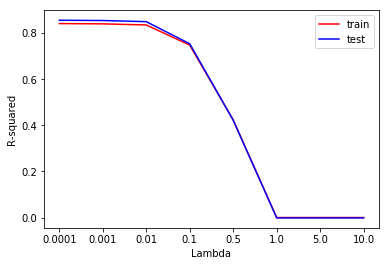

In [30]:
alpha_i = np.arange(len(alphas))
plt.plot(alpha_i, train_score,color='r',label='train')
plt.plot(alpha_i, test_score,color='b',label='test')
plt.ylabel('R-squared')
plt.xlabel('Lambda')
plt.xticks(alpha_i,alphas)
plt.legend(loc='upper right')
plt.show()

From both the output and the plot we can see that λ=0.001 gives us the highest R-squared value.

In [32]:
lasso_fit = Lasso(alpha=0.0001)
lasso_fit.fit(X_train, y_train)

C:\Users\Chang Liu\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
lasso_score = lasso_fit.score(X_test,y_test)
p_lasso_test = lasso_fit.predict(X_test)
lasso_MAE = mean_absolute_error(y_test, p_lasso_test)
print('Lasso Regression:')
print('R-squared value',round(lasso_score,5))
print('Mean Absolute Error',round(lasso_MAE,5))

Lasso Regression:
R-squared value 0.84259
Mean Absolute Error 0.28973


**2.5. Decision Tree:**

The goal of tree-based methods is to segment the feature space into a number of simple rectangular regions, to subsequently make a prediction for a given observation based on either mean or mode of the training observations in the region it belongs. Unlike most other classifiers, decision trees are simple models and models with class weight tuning. However, tree-based methods are typically not the best supervised learning method due to its accuracy. 

First we need to find the size of the tree that gives the best performance. 

In [38]:
initial_score_dt = 0
train_score_dt = []
test_score_dt = []
x_axis = []

for max_depth in range(1, 40, 5):
    decision_tree = DecisionTreeRegressor(max_depth=max_depth)
    r_train_dt,r_test_dt = train_and_get_score(decision_tree)
    train_score_dt.append(r_train_dt)
    test_score_dt.append(r_test_dt)
    x_axis.append(max_depth)
    if r_test_dt > initial_score_dt:
        print('Max depth:',max_depth, 'Train R-squared value:', round(r_train_dt,4), 
              'Test R-squared value:', round(r_test_dt,4))
        initial_score_dt = r_test_dt


Max depth: 1 Train R-squared value: 0.615 Test R-squared value: 0.5958
Max depth: 6 Train R-squared value: 0.8678 Test R-squared value: 0.8583
Max depth: 11 Train R-squared value: 0.947 Test R-squared value: 0.8716


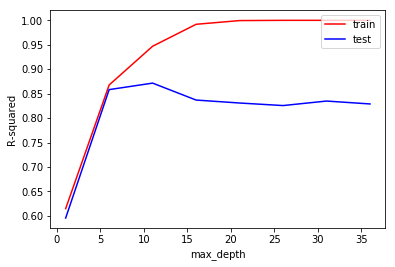

In [39]:
plt.plot(x_axis, train_score_dt,color='r',label='train')
plt.plot(x_axis, test_score_dt,color='b',label='test')
plt.ylabel('R-squared')
plt.xlabel('max_depth')
plt.legend(loc='upper right')
plt.show()

The output and the plot shows that overfitting occured during the training process. We can perform cross-validation on the training dataset to make sure we find the correct tree size.

In [54]:
parameters = {'max_depth':range(1,40,5)}
clf = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=5)
clf.fit(X=X_train[:10000], y=y_train[:10000])
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

C:\Users\Chang Liu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8477910506771419 {'max_depth': 6}


Based on the result of cross-validation, we can say that the decision tree model with a tree size of 6 gives the best performance because it has the smallest CV error.

In [55]:
dt_fit = DecisionTreeRegressor(max_depth=6)
dt_fit.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [56]:
dt_score = dt_fit.score(X_test,y_test)
p_dt_test = dt_fit.predict(X_test)
dt_MAE = mean_absolute_error(y_test, p_dt_test)
print('Decision Tree:')
print('R-squared value',round(dt_score,5))
print('Mean Absolute Error',round(dt_MAE,5))

Decision Tree:
R-squared value 0.86308
Mean Absolute Error 0.26425


**2.6.Random Forest** 

Random forest is essentially a collection of decision trees. Instead of using all the data at once, random forest selects random sets of predictors to build a large number of decision trees from and then averages the results. 

Those decision trees will choose which class they belong to, and the class with the highest population is the predicted class. This will help reduce our error due to bias and variance.

In [8]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.3 # % to use for validation set
n_valid = int(val_perc * 4442711) 
n_trn = len(df)-n_valid

In [9]:
# Split data
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(DF, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [10]:
# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (3109899, 41) Sample target shape:  (3109899,) Sample validation shape:  (1332813, 41)


In [11]:
from sklearn.ensemble import RandomForestRegressor
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [15]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.04127045700502189, 'mae val: ', 0.058907489732123175]


We set number of trees in the forest as 100 and got the MAE of 0.04127045700502189 for training data set and 0.058907489732123175 for test dataset. 

The result shows that variables that have feature importance above 0.05 are the following in the order of highest feature importance: walkDistance(feature19: 0.2743), killPlace(feature6: 0.2017), TotalDistance(feature 23: 0.1708), boosts(feature 1: 0.0773), weaponsAcquired(feature 20: 0.0702), and healsandboosts(feature24: 0.0514).

In [16]:
importances = m1.feature_importances_

Feature ranking:
1. feature 19 (0.236866)
2. feature 6 (0.222431)
3. feature 23 (0.203936)
4. feature 1 (0.059154)
5. feature 24 (0.057046)
6. feature 20 (0.039424)
7. feature 5 (0.037327)
8. feature 2 (0.019507)
9. feature 11 (0.016865)
10. feature 14 (0.016314)
11. feature 10 (0.015877)
12. feature 9 (0.012786)
13. feature 12 (0.012146)
14. feature 22 (0.009809)
15. feature 8 (0.007875)
16. feature 0 (0.006601)
17. feature 3 (0.005201)
18. feature 21 (0.002933)
19. feature 13 (0.002904)
20. feature 7 (0.002595)
21. feature 4 (0.002095)
22. feature 38 (0.002065)
23. feature 16 (0.002052)
24. feature 39 (0.001854)
25. feature 40 (0.001479)
26. feature 28 (0.000994)
27. feature 36 (0.000594)
28. feature 37 (0.000405)
29. feature 27 (0.000328)
30. feature 17 (0.000186)
31. feature 32 (0.000163)
32. feature 25 (0.000074)
33. feature 15 (0.000038)
34. feature 18 (0.000035)
35. feature 34 (0.000024)
36. feature 30 (0.000009)
37. feature 35 (0.000003)
38. feature 26 (0.000002)
39. feature 29

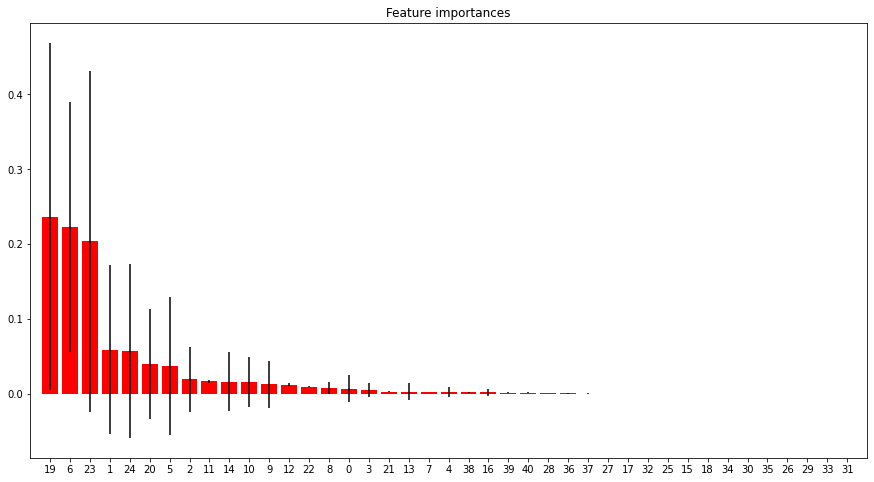

In [17]:
import matplotlib.pyplot as plt 
std = np.std([tree.feature_importances_ for tree in m1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (15,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.savefig('foo.png')

## 3. Result and Conclusion

From the result of the feature analysis, we found out that the walking distance, number of players killed, total distance traveled, number of boots used, number of weapons acquired and total number of boosts and heals used are the five most important features in determine the placement of a player. 

In the methods we choose for this project, random forest is the best model for predicting winning placements in PUBG. It has the smallest error compared with other predicting methods. 

Due to large amounts of data and complex non-linear relationships between predictors and responses, linear regression methods such as ridge and lasso do not work well as intended. Tree models on the other hand, perform well in these situations.

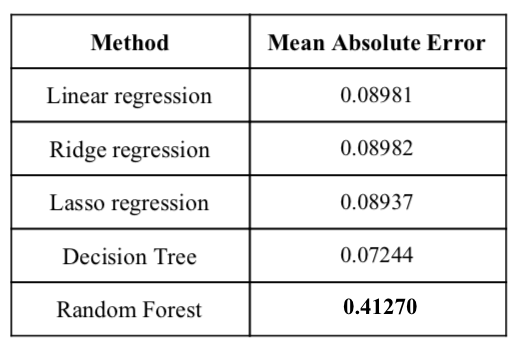

In [3]:
from IPython.display import Image
Image("Result_table.png")

We saw that decision trees are prone to **overfitting**. There are several ways to avoid this problem: 

first we can choose a testing set that do not perform like the training set, so that we can easily detect overfitting.

Next we should try to reduce the complexity of the decision tree model. Grow a very large tree at first, and then prune it back in order to obtain a subtree. This method is called Tree Pruning. Have enough data on every aspect also helps in reducing overfitting.

In order to further reduce the error, we could try to apply PCA for tree models. 

PCA reduces the dimensionality of the dataset. With less number of features, tree models can hopefully give better performance.

**References**

- KP (2018), “PUBG Finish Placement Prediction (Kernels Only)”, Kaggle.com, Link: ​https://www.kaggle.com/c/pubg-finish-placement-prediction

- Will Koehrsen (Dec 28, 2017), “Random Forest in Python”, towardsdatascience.com, Link: ​https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

- Chris Albon (Dec 20, 2017), “Visualize A Decision Tree”, chrisalbon.com,Link:​https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/

- Pratap Dangeti (2017), “Statistics for Machine Learning”

- Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani (2014), “An Introduction to Statistical Learning” 

- Robert Alvarez(Jun 04, 2018), “Creating Diagnostic Plots in Python”

- Link: ​https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/